<h2>Import libraries</h2>

In [66]:
%reload_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import os
from PIL import Image
import cv2
from sklearn.utils import shuffle
sys.path.append(str(Path.cwd().parent))
from src.make_dataset import *
import matplotlib.pyplot as plt
from loguru import logger
import numpy as np
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array

# Utiliser tensorflow.keras au lieu de keras directement
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from src.trainer import ImageTrainer, resize_images
import mlflow
import mlflow.sklearn
import logging
from datetime import datetime
from src.utils import plot_confusion_matrix
from src.utils import save_best_model_by_val_accuracy


<h2>Settings</h2>

In [67]:
project_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(project_dir, 'data', 'Garbage classification','Garbage classification')
logger.info(f"\nProject directory: {project_dir} \nData directory: {data_path}")

# # Configure logger
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

2024-08-07 20:17:54.559 | INFO     | __main__:<module>:3 - 
Project directory: c:\Users\ext_lagnane005147\Documents\Cours\Garbage-Classification 
Data directory: c:\Users\ext_lagnane005147\Documents\Cours\Garbage-Classification\data\Garbage classification\Garbage classification


<h2>Data Collection</h2>

In [68]:
images, labels = load_data(False)
# Afficher le nombre d'images et de labels chargés
print(f'Nombre d\'images chargées: {len(images)}')
print(f'Nombre de labels chargés: {len(labels)}')

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
Dataset 'asdasdasasdas/garbage-classification' downloaded to 'c:\Users\ext_lagnane005147\Documents\Cours\Garbage-Classification\data'.


2024-08-07 20:19:24.676 | INFO     | src.make_dataset:load_data:75 - Directories: c:\Users\ext_lagnane005147\Documents\Cours\Garbage-Classification\data,c:\Users\ext_lagnane005147\Documents\Cours\Garbage-Classification
2024-08-07 20:19:24.676 | INFO     | src.make_dataset:load_data:76 - Dataset lo load: c:\Users\ext_lagnane005147\Documents\Cours\Garbage-Classification\data\Garbage classification\Garbage classification
2024-08-07 20:19:24.681 | INFO     | src.make_dataset:load_data:77 - Data shape: Images: 2527, Labels: 2527


Nombre d'images chargées: 2527
Nombre de labels chargés: 2527


<h2>EDA: Exploratory Data Analysis</h2>

In [69]:
labels[2500]

'metal'

In [70]:
images[2500]

array([[[189, 196, 245],
        [189, 196, 245],
        [189, 196, 245],
        ...,
        [163, 179, 246],
        [163, 179, 246],
        [163, 179, 246]],

       [[189, 196, 245],
        [189, 196, 245],
        [189, 196, 245],
        ...,
        [163, 179, 246],
        [163, 179, 246],
        [163, 179, 246]],

       [[189, 196, 245],
        [189, 196, 245],
        [189, 196, 245],
        ...,
        [163, 179, 246],
        [163, 179, 246],
        [163, 179, 246]],

       ...,

       [[196, 181, 165],
        [196, 181, 165],
        [196, 181, 165],
        ...,
        [165, 156, 143],
        [165, 156, 143],
        [165, 156, 143]],

       [[196, 181, 165],
        [196, 181, 165],
        [196, 181, 165],
        ...,
        [165, 156, 143],
        [165, 156, 143],
        [165, 156, 143]],

       [[196, 181, 165],
        [196, 181, 165],
        [196, 181, 165],
        ...,
        [165, 156, 143],
        [165, 156, 143],
        [165, 156, 143]]

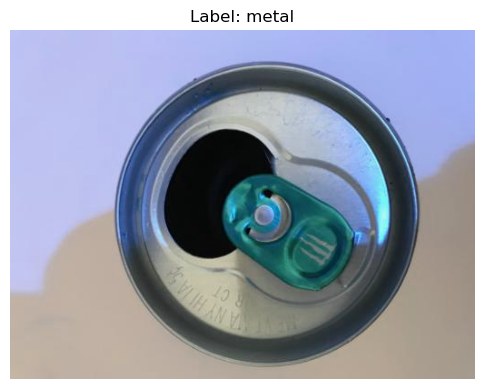

In [71]:
# Afficher l'image avec son label
plt.figure(figsize=(6, 6))
plt.imshow(images[2500])
plt.title(f"Label: {labels[2500]}")
plt.axis('off')
plt.show()

In [72]:
# List categories
categories = os.listdir(data_path)
print("Categories:", categories)

Categories: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


           Count
cardboard    403
glass        501
metal        410
paper        594
plastic      482
trash        137


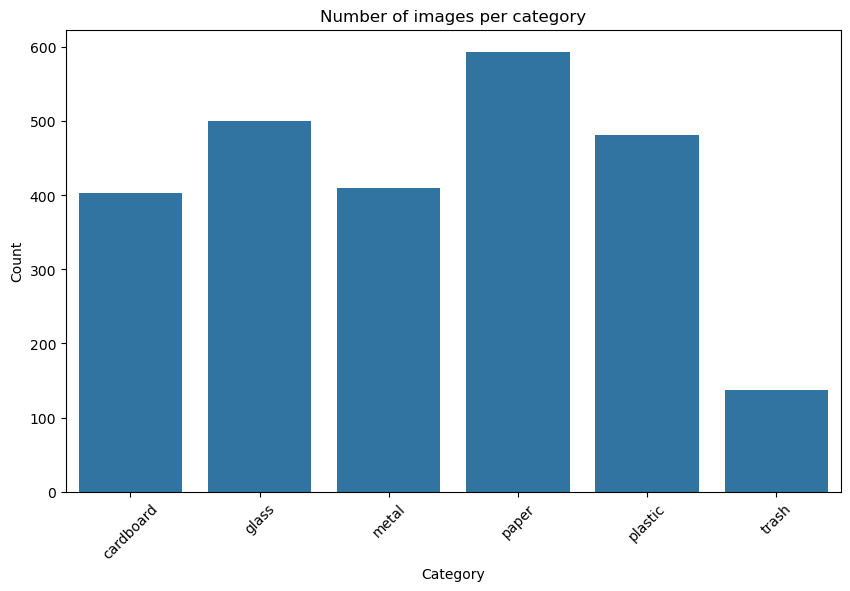

In [73]:
# Count the number of images in each category
category_counts = {category: len(os.listdir(os.path.join(data_path, category))) for category in categories}
category_counts_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count'])
print(category_counts_df)

# Plot the number of images per category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts_df.index, y=category_counts_df['Count'])
plt.title('Number of images per category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

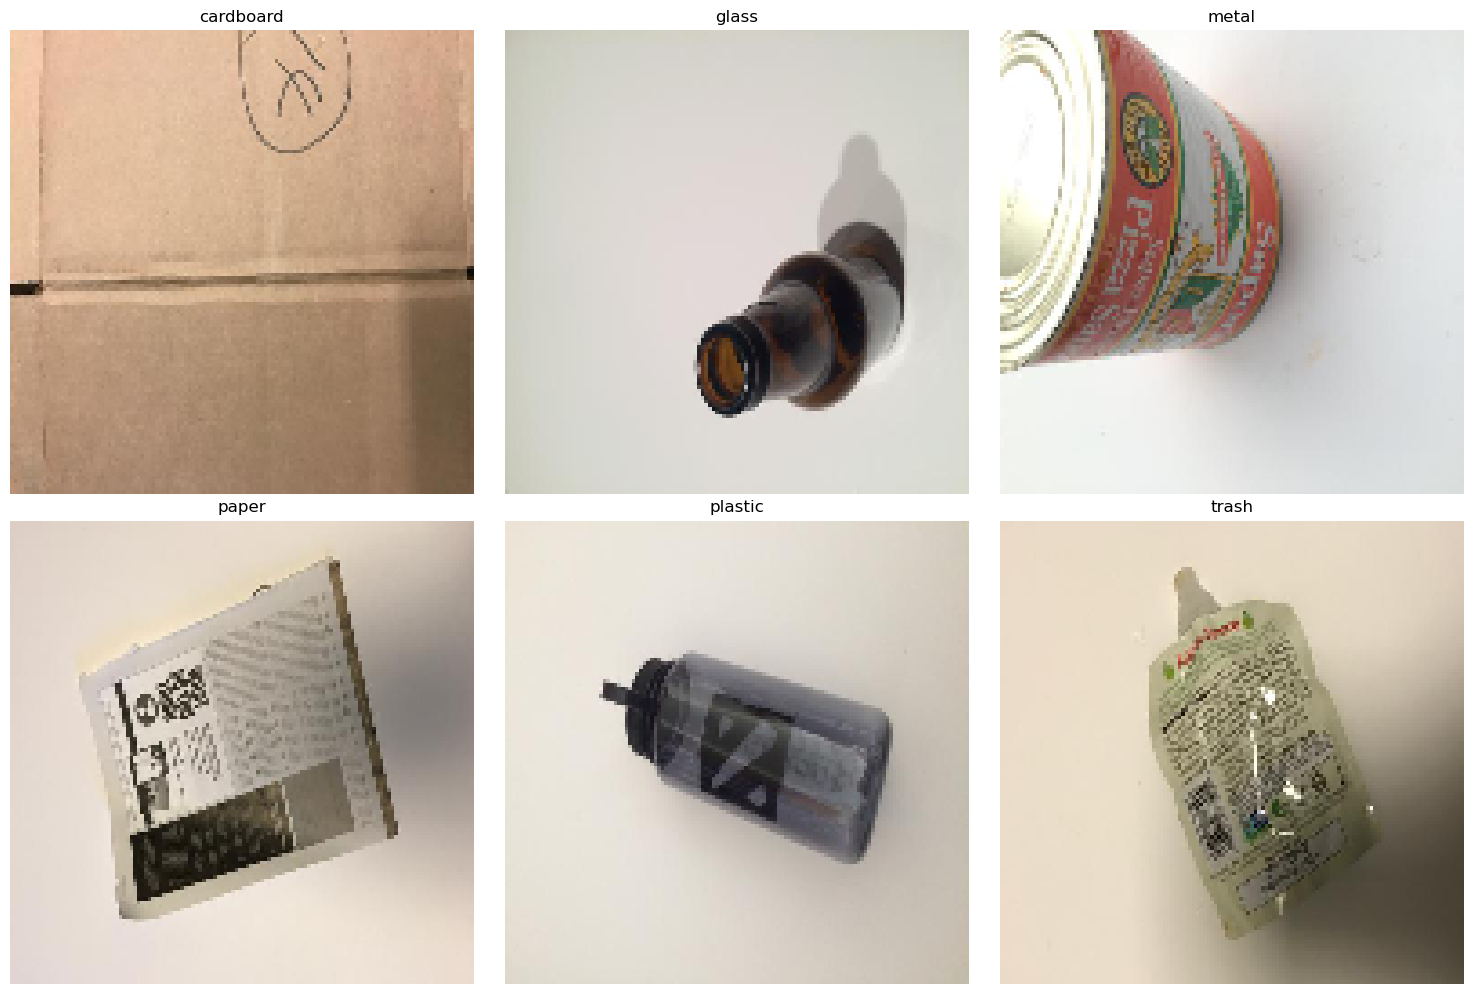

In [74]:
# Cell 4: Visualize some images from each category
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    img_path = os.path.join(data_path, category, os.listdir(os.path.join(data_path, category))[0])
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_array)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [75]:
# Initialize a list to store image dimensions
image_dimensions = []

# Iterate over each category and each image within the category
for category in categories:
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        with Image.open(img_path) as img:
            image_dimensions.append(img.size)  # img.size returns (width, height)

# Convert the list of dimensions to a DataFrame for better analysis
image_dimensions_df = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])

# Check if all dimensions are the same
unique_dimensions = image_dimensions_df.drop_duplicates()
if len(unique_dimensions) == 1:
    print(f"All images have the same size: {unique_dimensions.iloc[0].to_dict()}")
else:
    print("Not all images have the same size.")
    print("Different image sizes found:")
    print(unique_dimensions)


All images have the same size: {'Width': 512, 'Height': 384}


<h1>Modeling</h1>

In [76]:
def create_cnn_model(input_shape=(128, 128, 3), num_classes=6):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [77]:
cnn_model = create_cnn_model(input_shape=(128, 128, 3), num_classes=6)

c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 534ms/step - accuracy: 0.2034 - loss: 121.2649 - val_accuracy: 0.2438 - val_loss: 1.8354
Epoch 2/20
 1/55 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - accuracy: 0.2188 - loss: 1.6479

c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2188 - loss: 1.6479 - val_accuracy: 0.2692 - val_loss: 2.0744
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 505ms/step - accuracy: 0.2351 - loss: 1.8447 - val_accuracy: 0.2458 - val_loss: 1.7072
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 1.7472 - val_accuracy: 0.2692 - val_loss: 1.7351
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 487ms/step - accuracy: 0.2641 - loss: 1.7156 - val_accuracy: 0.2271 - val_loss: 1.7370
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1250 - loss: 1.8713 - val_accuracy: 0.1923 - val_loss: 1.7540
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 578ms/step - accuracy: 0.2513 - loss: 1.7827 - val_accuracy: 0.2438 - val_loss: 1.7228
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2188 - loss: 1.7269 - val_accuracy: 0.2308 - val_loss: 1.7255
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 629ms/step - accuracy: 0.2554 - loss: 1.7257 - val_accuracy: 0.2396 - val_loss

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

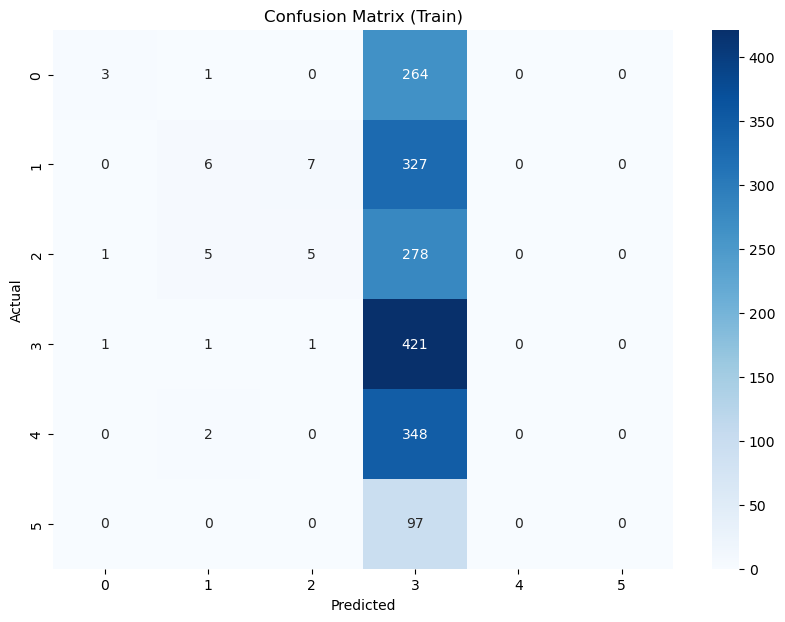

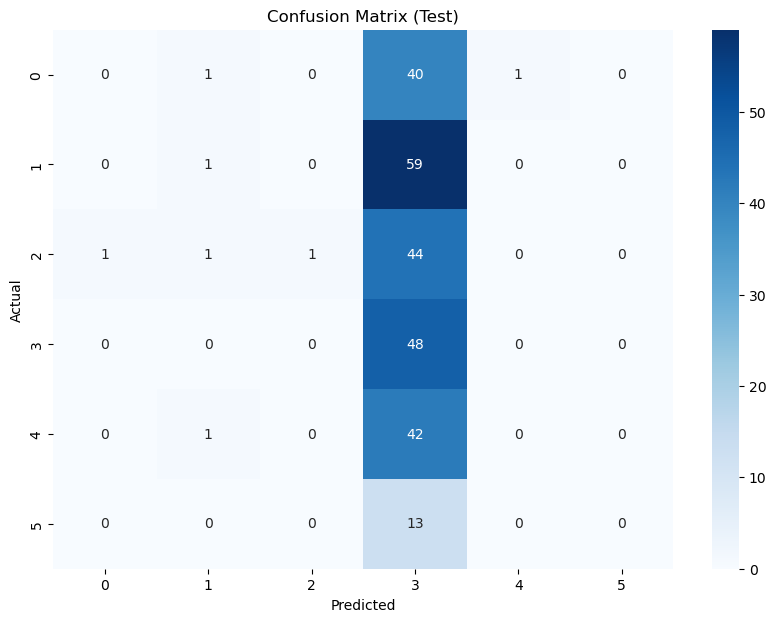

In [78]:
# Créer une instance de ImageTrainer avec les images, labels et le modèle
trainer = ImageTrainer(data=images, labels=labels, model=cnn_model)

# Entraîner le modèle et évaluer les métriques
train_metrics, val_metrics, test_metrics, sk_model = trainer.train()
# Plot confusion matrix
plot_confusion_matrix(train_metrics["confusion_matrix"], "Confusion Matrix (Train)")
plot_confusion_matrix(test_metrics["confusion_matrix"], "Confusion Matrix (Test)")


<h2>Tester d'autres modéles</h2>

In [79]:
def create_resnet_model(input_shape=(128, 128, 3), num_classes=6):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_vgg19_model(input_shape=(128, 128, 3), num_classes=6):
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_inception_model(input_shape=(128, 128, 3), num_classes=6):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [80]:
# Define models and parameters to benchmark
ESTIMATOR_PARAMS = {
    "VGG16": {"estimator": create_vgg19_model, "params": {"input_shape": (128, 128, 3), "num_classes": 6}},
    "InceptionV3": {"estimator": create_inception_model, "params": {"input_shape": (128, 128, 3), "num_classes": 6}},
    "CNN": {"estimator": create_cnn_model, "params": {"input_shape": (128, 128, 3), "num_classes": 6}},
    "ResNet50": {"estimator": create_resnet_model, "params": {"input_shape": (128, 128, 3), "num_classes": 6}},
}

In [81]:
# Create an experiment if not exists
exp_name = "garbage-classification"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id

logger.info(f"Experiment id: {experiment_id}")

2024-08-07 20:26:50.212 | INFO     | __main__:<module>:9 - Experiment id: 505649261849573164


In [82]:
input_shape = (128, 128, 3)  
num_classes = len(np.unique(labels))

# Loop through the models and their configurations
for model_name, model_configs in ESTIMATOR_PARAMS.items():
    logger.info(f"{model_name} \n{model_configs}")

    estimator = model_configs["estimator"]
    params = model_configs["params"]

    # Initialiser le modèle Keras directement
    model = estimator(**params)
    
    # Initialize and use the ImageTrainer with the current model and data augmentation
    trainer = ImageTrainer(data=images, labels=labels, model=model)
    train_metrics, val_metrics, test_metrics, trained_model = trainer.train()
    
    # Convert confusion matrix to DataFrame
    class_names = list(trainer.label_mapping.keys())  # Get class names from label mapping
    train_conf_matrix_df = pd.DataFrame(train_metrics["confusion_matrix"], index=class_names, columns=class_names)
    val_conf_matrix_df = pd.DataFrame(val_metrics["confusion_matrix"], index=class_names, columns=class_names)
    test_conf_matrix_df = pd.DataFrame(test_metrics["confusion_matrix"], index=class_names, columns=class_names)

    # Start MLflow run
    run_name = f"{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        # Log parameters
        mlflow.log_params({
            "model_name": model_name,
            "target_size": trainer.target_size,
            "batch_size": trainer.batch_size,
            "epochs": trainer.epochs,
            "test_size": trainer.test_size,
            "random_state": trainer.random_state
        })

        # Log metrics
        mlflow.log_metrics({
            "train_accuracy": train_metrics["accuracy"],
            "val_accuracy": val_metrics["accuracy"],
            "test_accuracy": test_metrics["accuracy"]
        })
        # Log classification report as CSV
        train_metrics["classification_report"].to_csv("train_classification_report.csv")
        val_metrics["classification_report"].to_csv("val_classification_report.csv")
        test_metrics["classification_report"].to_csv("test_classification_report.csv")
        mlflow.log_artifact("train_classification_report.csv")
        mlflow.log_artifact("val_classification_report.csv")
        mlflow.log_artifact("test_classification_report.csv")

        # Log confusion matrix as CSV
        train_conf_matrix_df.to_csv("train_confusion_matrix.csv")
        val_conf_matrix_df.to_csv("val_confusion_matrix.csv")
        test_conf_matrix_df.to_csv("test_confusion_matrix.csv")
        mlflow.log_artifact("train_confusion_matrix.csv")
        mlflow.log_artifact("val_confusion_matrix.csv")
        mlflow.log_artifact("test_confusion_matrix.csv")

        # Log model
        mlflow.keras.log_model(trained_model, artifact_path=f"model_{model_name}")

2024-08-07 20:26:56.158 | INFO     | __main__:<module>:6 - VGG16 
{'estimator': <function create_vgg19_model at 0x000001A3E7CA51C0>, 'params': {'input_shape': (128, 128, 3), 'num_classes': 6}}


Epoch 1/20


c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.4777 - loss: 3.7553 - val_accuracy: 0.6792 - val_loss: 1.7726
Epoch 2/20
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.7188 - loss: 1.1173

c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7188 - loss: 1.1173 - val_accuracy: 0.5385 - val_loss: 2.4020
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.7664 - loss: 1.0147 - val_accuracy: 0.6625 - val_loss: 1.6578
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6875 - loss: 1.3053 - val_accuracy: 0.7308 - val_loss: 1.7597
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.7692 - loss: 0.7985 - val_accuracy: 0.7729 - val_loss: 0.8800
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8125 - loss: 0.6315 - val_accuracy: 0.6923 - val_loss: 0.7841
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.8547 - loss: 0.4021 - val_accuracy: 0.7875 - val_loss: 0.8689
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8125 - loss: 0.2816 - val_accuracy: 0.8077 - val_loss: 0.6484
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8729 - loss: 0.3672 - val_accuracy: 0.8042 - val_loss: 0.8

2024-08-07 20:50:43.220 | INFO     | src.trainer:train:166 - Train metrics: {'accuracy': 0.958710407239819, 'classification_report':               precision    recall  f1-score     support
cardboard      1.000000  0.955224  0.977099   268.00000
glass          0.910082  0.982353  0.944837   340.00000
metal          0.946128  0.972318  0.959044   289.00000
paper          0.972028  0.983491  0.977726   424.00000
plastic        0.993631  0.891429  0.939759   350.00000
trash          0.904762  0.979381  0.940594    97.00000
accuracy       0.958710  0.958710  0.958710     0.95871
macro avg      0.954438  0.960699  0.956510  1768.00000
weighted avg   0.960708  0.958710  0.958699  1768.00000, 'confusion_matrix': array([[256,   2,   2,   8,   0,   0],
       [  0, 334,   3,   1,   2,   0],
       [  0,   6, 281,   1,   0,   1],
       [  0,   1,   3, 417,   0,   3],
       [  0,  23,   8,   1, 312,   6],
       [  0,   1,   0,   1,   0,  95]], dtype=int64)}
2024-08-07 20:50:43.227 | INFO     | 

Epoch 1/20


c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 58s 675ms/step - accuracy: 0.2289 - loss: 209.4715 - val_accuracy: 0.3229 - val_loss: 12.9984
Epoch 2/20
 1/55 ━━━━━━━━━━━━━━━━━━━━ 19s 352ms/step - accuracy: 0.3125 - loss: 10.8114

c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3125 - loss: 10.8114 - val_accuracy: 0.2308 - val_loss: 18.8538
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 527ms/step - accuracy: 0.3491 - loss: 10.1390 - val_accuracy: 0.2854 - val_loss: 12.3879
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3125 - loss: 8.3698 - val_accuracy: 0.2692 - val_loss: 13.7035
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 529ms/step - accuracy: 0.3246 - loss: 9.2840 - val_accuracy: 0.3562 - val_loss: 7.3818
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3125 - loss: 6.6043 - val_accuracy: 0.3846 - val_loss: 7.5882
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 519ms/step - accuracy: 0.3538 - loss: 5.8770 - val_accuracy: 0.3438 - val_loss: 5.8443
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7500 - loss: 1.5825 - val_accuracy: 0.3077 - val_loss: 6.5103
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 519ms/step - accuracy: 0.3401 - loss: 5.6085 - val_accuracy: 0.3688 - v

2024-08-07 20:58:05.145 | INFO     | src.trainer:train:166 - Train metrics: {'accuracy': 0.41346153846153844, 'classification_report':               precision    recall  f1-score      support
cardboard      0.408629  0.600746  0.486405   268.000000
glass          0.333851  0.632353  0.436992   340.000000
metal          0.381250  0.211073  0.271715   289.000000
paper          0.528785  0.584906  0.555431   424.000000
plastic        0.695652  0.091429  0.161616   350.000000
trash          0.254545  0.144330  0.184211    97.000000
accuracy       0.413462  0.413462  0.413462     0.413462
macro avg      0.433785  0.377473  0.349395  1768.000000
weighted avg   0.466955  0.413462  0.377487  1768.000000, 'confusion_matrix': array([[161,  48,  21,  32,   2,   4],
       [ 44, 215,  16,  46,   6,  13],
       [ 66,  83,  61,  69,   0,  10],
       [ 48,  93,  29, 248,   4,   2],
       [ 58, 164,  23,  61,  32,  12],
       [ 17,  41,  10,  13,   2,  14]], dtype=int64)}
2024-08-07 20:58:05.151 |

Epoch 1/20


c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 613ms/step - accuracy: 0.2247 - loss: 87.4604 - val_accuracy: 0.2479 - val_loss: 1.7473
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4062 - loss: 1.7035 - val_accuracy: 0.4231 - val_loss: 1.7134
Epoch 3/20


c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 587ms/step - accuracy: 0.2683 - loss: 1.7371 - val_accuracy: 0.2354 - val_loss: 1.7597
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2500 - loss: 1.7904 - val_accuracy: 0.3077 - val_loss: 1.6965
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 614ms/step - accuracy: 0.2651 - loss: 1.6895 - val_accuracy: 0.2792 - val_loss: 1.6900
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2812 - loss: 1.7173 - val_accuracy: 0.2692 - val_loss: 1.6731
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 576ms/step - accuracy: 0.2798 - loss: 1.6756 - val_accuracy: 0.2396 - val_loss: 1.7313
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1875 - loss: 1.6844 - val_accuracy: 0.1538 - val_loss: 1.7531
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 526ms/step - accuracy: 0.2666 - loss: 1.7203 - val_accuracy: 0.1958 - val_loss: 1.7162
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2188 - loss: 1.7398 - val_accuracy: 0.1538 - val_los

c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Epoch 1/20


c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4986 - loss: 2.4013 - val_accuracy: 0.7896 - val_loss: 0.5925
Epoch 2/20
 1/55 ━━━━━━━━━━━━━━━━━━━━ 41s 768ms/step - accuracy: 0.7188 - loss: 0.8415

c:\Users\ext_lagnane005147\AppData\Local\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7188 - loss: 0.8415 - val_accuracy: 0.8846 - val_loss: 0.5497
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8240 - loss: 0.5131 - val_accuracy: 0.8188 - val_loss: 0.5452
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8750 - loss: 0.2774 - val_accuracy: 0.8462 - val_loss: 0.6124
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8310 - loss: 0.4421 - val_accuracy: 0.8146 - val_loss: 0.5285
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8750 - loss: 0.3358 - val_accuracy: 0.8077 - val_loss: 0.4852
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8864 - loss: 0.3156 - val_accuracy: 0.8396 - val_loss: 0.5050
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9688 - loss: 0.1872 - val_accuracy: 0.8077 - val_loss: 0.6680
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9045 - loss: 0.2714 - val_accuracy: 0.8458 - val_loss: 0.4944

2024-08-07 21:16:59.661 | INFO     | src.trainer:train:166 - Train metrics: {'accuracy': 0.9722850678733032, 'classification_report':               precision    recall  f1-score      support
cardboard      0.988889  0.996269  0.992565   268.000000
glass          0.964392  0.955882  0.960118   340.000000
metal          0.936877  0.975779  0.955932   289.000000
paper          0.985948  0.992925  0.989424   424.000000
plastic        0.996979  0.942857  0.969163   350.000000
trash          0.921569  0.969072  0.944724    97.000000
accuracy       0.972285  0.972285  0.972285     0.972285
macro avg      0.965776  0.972131  0.968654  1768.000000
weighted avg   0.972879  0.972285  0.972326  1768.000000, 'confusion_matrix': array([[267,   0,   0,   1,   0,   0],
       [  0, 325,  13,   0,   1,   1],
       [  0,   2, 282,   1,   0,   4],
       [  2,   0,   1, 421,   0,   0],
       [  0,  10,   5,   2, 330,   3],
       [  1,   0,   0,   2,   0,  94]], dtype=int64)}
2024-08-07 21:16:59.665 | 

In [85]:
experiment_name = "garbage-classification"
parent_directory = os.path.dirname(os.getcwd())
save_directory = os.path.join(parent_directory, "API")
save_best_model_by_val_accuracy(experiment_name, save_directory)

Best run ID: 6c407701bf0743ca8a571216d2ccdaf4
Validation Accuracy: 0.8616600790513834


Best model saved to c:\Users\ext_lagnane005147\Documents\Cours\Garbage-Classification\API\best_model.h5


<h2>Test du model

(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


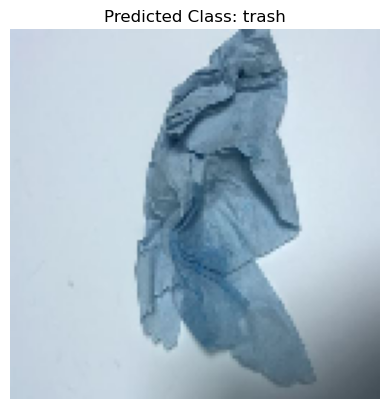

In [93]:
# Chemin vers le modèle sauvegardé
model_path = os.path.join(os.path.dirname(os.getcwd()), "API", "best_model.h5")

# Charger le modèle
model = load_model(model_path)

# Fonction pour prédire la classe de l'image
def predict_image(model, image_path, categories):
    img_array = cv2.imread(image_path)
    image = resize_images([img_array])
    print(image.shape)
    predictions = model.predict(image)
    category = np.argmax(predictions, axis=1)
    predicted_category = categories[category[0]]
    return predicted_category, img_array

# Chemin vers l'image de test
image_path = os.path.join(os.path.dirname(os.getcwd()), "data_split", "test", "5", "image_213.png")

# Prédire la classe de l'image
predicted_category, image = predict_image(model, image_path, categories)

# Afficher l'image et la classe prédite
img = load_img(image_path)
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_category}")
plt.axis('off')
plt.show()